# Titanic: Machine Learning from Disaster
## Version #2: Logistic Regression

__Problem__ 
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

__Algorithm__ Let's try to use LogisticRegression.

In [93]:
%matplotlib inline
import pandas as pd
import math
import numpy as np
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib import pyplot as plt
from sklearn import cross_validation, feature_extraction, grid_search, linear_model, preprocessing

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams

rcParams['figure.figsize'] = 6, 4
import re
random_state = 153

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

## Variable description
* `survival`: (0 = No; 1 = Yes)
* `pclass`: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* `name`
* `sex`
* `age`
* `sibsp`: Number of Siblings/Spouses Aboard
* `parch`: Number of Parents/Children Aboard
* `ticket`: Ticket Number
* `fare`: Passenger Fare
* `cabin`  
* `embarked`: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

### Special notes
`Pclass` is a proxy for socio-economic status (SES): 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

`Age` is in years; fractional if age less than one. If the `Age` is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. `sibsp` and `parch`) some relations were ignored.  The following are the definitions used for `sibsp` and `parch`.
 * _Sibling_ - Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
 * _Spouse_ - Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
 * _Parent_ - Mother or Father of Passenger Aboard Titanic
 * _Child_ - Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws.  Some children travelled only with a nanny, therefore `parch=0` for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

In [6]:
title_re = re.compile('([ \w\'-]+), (\w+)')

def determine_title(name):
    title = title_re.match(name).groups()[1]
    if title in ['Mr', 'Miss', 'Master', 'Mrs']:
        return title
    elif title == 'Mme':
        return 'Mrs'
    elif title == 'Ms':
        return 'Miss'
    elif title == 'Mlle':
        return 'Miss'
    else:
        return 'other'

def determine_family_size(sibsp, parch):
    n = sibsp + parch
    if n == 0:
        return 'alone'
    elif n in [1, 2, 3]:
        return 'small'
    else:
        return 'large'
    
data_train['title'] = map(determine_title, data_train.Name)

## Data preprocessing

In [120]:
X_train = data_train.drop('Survived', axis = 1)
X_test = data_test

y_train = data_train.Survived

In [121]:
X_train['family_size'] = map(determine_family_size, X_train.SibSp, X_train.Parch)
X_test['family_size'] = map(determine_family_size, X_test.SibSp, X_test.Parch)

In [122]:
X_train['title'] = map(determine_title, X_train.Name)
X_test['title'] = map(determine_title, X_test.Name)

In [123]:
numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch']
escape_cols = ['PassengerId', 'Name', 'Ticket'] # not used data
target_cols = ['Survived']
categorical_cols = list(set(data_train.columns) - set(numeric_cols) - set(escape_cols) - set(target_cols))

### Dealing with NAs

In [124]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [125]:
X_num_train = X_train[numeric_cols]
X_cat_train = X_train[categorical_cols]

X_num_test = X_test[numeric_cols]
X_cat_test = X_test[categorical_cols]

In [126]:
# for numeric values let's fill missing values with medians
X_num_train = X_num_train.fillna(X_num_train.median())
X_num_test = X_num_test.fillna(X_num_train.median())

In [127]:
# for Embarkment let's fill missing values with most common value
embarkment_mode = X_cat_train.Embarked.mode().values[0]
X_cat_train.Embarked.fillna(embarkment_mode, inplace = True)
X_cat_test.Embarked.fillna(embarkment_mode, inplace = True)

In [128]:
# Also we found out that there are a lot of adult passengers that has fare equals to 0, that looks like a mistake, 
# so let's change it also to median
fare_median = X_num_train.Fare.median()
X_num_train['Fare'] = map(lambda x: x if x != 0 else fare_median, X_num_train.Fare)
X_num_test['Fare'] = map(lambda x: x if x != 0 else fare_median, X_num_test.Fare)

In [129]:
X_cat_train.Cabin.fillna('unknown', inplace = True)
X_cat_test.Cabin.fillna('unknown', inplace = True)

### Dealing with categorical variables

In [130]:
X_cat_train['Sex'] = map(lambda x: int(x == 'male'), X_cat_train.Sex)
X_cat_test['Sex'] = map(lambda x: int(x == 'male'), X_cat_test.Sex)

/Users/miptgirl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/miptgirl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [131]:
encoder = feature_extraction.DictVectorizer()
X_cat_train_enc = encoder.fit_transform(X_cat_train.T.to_dict().values())
X_cat_train_enc = pd.DataFrame(X_cat_train_enc.toarray())
X_cat_train_enc.columns = encoder.get_feature_names()
print encoder.get_feature_names()

['Cabin=A10', 'Cabin=A14', 'Cabin=A16', 'Cabin=A19', 'Cabin=A20', 'Cabin=A23', 'Cabin=A24', 'Cabin=A26', 'Cabin=A31', 'Cabin=A32', 'Cabin=A34', 'Cabin=A36', 'Cabin=A5', 'Cabin=A6', 'Cabin=A7', 'Cabin=B101', 'Cabin=B102', 'Cabin=B18', 'Cabin=B19', 'Cabin=B20', 'Cabin=B22', 'Cabin=B28', 'Cabin=B3', 'Cabin=B30', 'Cabin=B35', 'Cabin=B37', 'Cabin=B38', 'Cabin=B39', 'Cabin=B4', 'Cabin=B41', 'Cabin=B42', 'Cabin=B49', 'Cabin=B5', 'Cabin=B50', 'Cabin=B51 B53 B55', 'Cabin=B57 B59 B63 B66', 'Cabin=B58 B60', 'Cabin=B69', 'Cabin=B71', 'Cabin=B73', 'Cabin=B77', 'Cabin=B78', 'Cabin=B79', 'Cabin=B80', 'Cabin=B82 B84', 'Cabin=B86', 'Cabin=B94', 'Cabin=B96 B98', 'Cabin=C101', 'Cabin=C103', 'Cabin=C104', 'Cabin=C106', 'Cabin=C110', 'Cabin=C111', 'Cabin=C118', 'Cabin=C123', 'Cabin=C124', 'Cabin=C125', 'Cabin=C126', 'Cabin=C128', 'Cabin=C148', 'Cabin=C2', 'Cabin=C22 C26', 'Cabin=C23 C25 C27', 'Cabin=C30', 'Cabin=C32', 'Cabin=C45', 'Cabin=C46', 'Cabin=C47', 'Cabin=C49', 'Cabin=C50', 'Cabin=C52', 'Cabin=C54'

In [132]:
X_cat_test_enc = encoder.transform(X_cat_test.T.to_dict().values())
X_cat_test_enc = pd.DataFrame(X_cat_test_enc.toarray())
X_cat_test_enc.columns = encoder.get_feature_names()

In [133]:
scaler = preprocessing.StandardScaler()
X_num_train_scaled = pd.DataFrame(scaler.fit_transform(X_num_train))
X_num_train_scaled.columns = X_num_train.columns

X_num_test_scaled = pd.DataFrame(scaler.transform(X_num_test))
X_num_test_scaled.columns = X_num_test.columns

### Summing up

In [134]:
X_train = pd.concat([X_num_train_scaled, X_cat_train_enc], axis = 1)
X_test = pd.concat([X_num_test_scaled, X_cat_test_enc], axis = 1)

## Tuning RandomForest params 

In [135]:
clf = linear_model.LogisticRegression()
clf.get_params().keys()

['warm_start',
 'C',
 'n_jobs',
 'verbose',
 'intercept_scaling',
 'fit_intercept',
 'max_iter',
 'penalty',
 'multi_class',
 'random_state',
 'dual',
 'tol',
 'solver',
 'class_weight']

In [136]:
parameters_grid = {
    'C': [0.001, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

In [137]:
clf = linear_model.LogisticRegression()
grid_cv = grid_search.GridSearchCV(clf, parameters_grid, cv = 5, verbose = 100)

In [138]:
%%time
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 44 candidates, totalling 220 fits
[CV] penalty=l1, C=0.001, class_weight=None ..........................
[CV] . penalty=l1, C=0.001, class_weight=None, score=0.614525 -   0.0s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[CV] penalty=l1, C=0.001, class_weight=None ..........................
[CV] . penalty=l1, C=0.001, class_weight=None, score=0.614525 -   0.0s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    0.0s
[CV] penalty=l1, C=0.001, class_weight=None ..........................
[CV] . penalty=l1, C=0.001, class_weight=None, score=0.617978 -   0.0s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:    0.0s
[CV] penalty=l1, C=0.001, class_weight=None ..........................
[CV] . penalty=l1, C=0.001, class_weight=None, score=0.617978 -   0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.0s
[CV] penalty=l1, C=0.001, class_weight=None ..........................
[CV] . penalty=l1, C=0.001, class_weight=None, scor

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=100)

In [139]:
best_params = grid_cv.best_params_
best_C = best_params['C']
best_class_weight = best_params['class_weight']
best_penalty = best_params['penalty']
best_params

{'C': 1, 'class_weight': None, 'penalty': 'l2'}

In [140]:
grid_cv.best_score_

0.82940516273849607

In [141]:
scores = []
for elem in grid_cv.grid_scores_:
    scores.append(elem[1])

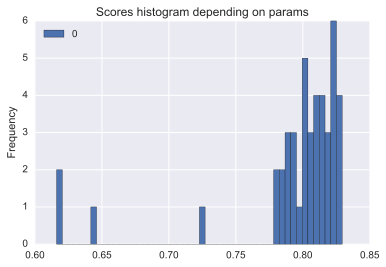

In [142]:
pd.DataFrame(scores).plot.hist(bins = 50, title = 'Scores histogram depending on params')

In [143]:
clf = linear_model.LogisticRegression(C = best_C, 
                                      class_weight = best_class_weight,
                                      penalty = best_penalty
                                     )
clf.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [144]:
predictions = clf.predict(X_test)

In [145]:
pd.DataFrame({'PassengerId': data_test.PassengerId.tolist(), 
              'Survived': predictions}).to_csv('predictions_logistic_regression.csv', index = False)